In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib qt

# Centre Voltage Sweep

In [16]:
cen_v= pd.read_csv('./2019-06-29/phi0_daedalus_voltCenter_calib_2019-06-29_2.csv', comment="#")

In [17]:
cen_vn = cen_v[cen_v.Yfield>0]
cen_vp = cen_v[cen_v.Yfield<0]

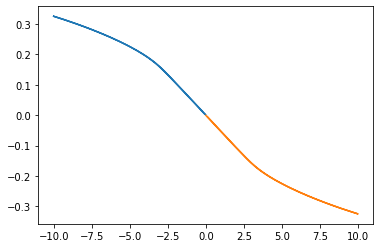

In [18]:
plt.figure()
plt.plot(cen_vn.V.values, cen_vn.Yfield.values)
plt.plot(cen_vp.V.values, cen_vp.Yfield.values)

In [65]:
cen_vp_coeff = np.polyfit(cen_vp.Yfield.values, cen_vp.V.values, 5)
cen_vn_coeff = np.polyfit(cen_vn.Yfield.values, cen_vn.V.values, 5)
cen_v_coeffs = np.asarray([cen_vn_coeff, cen_vp_coeff])
print(cen_v_coeffs)

[[ 4.16168895e+03 -3.11844226e+03  5.47011535e+02 -2.84592899e+01
  -1.86123341e+01  8.26244300e-03]
 [ 4.15146313e+03  3.09829665e+03  5.35103810e+02  2.63857442e+01
  -1.86952107e+01 -1.33786176e-02]]


In [66]:
np.savetxt("./icarusCalibCsv/icarus_volt_center_calib.csv", cen_v_coeffs, delimiter=",")

In [21]:
cen_vp_fit = np.poly1d(cen_vp_coeff)
cen_vn_fit = np.poly1d(cen_vn_coeff)

Text(0.5, 1.0, 'B(V)')

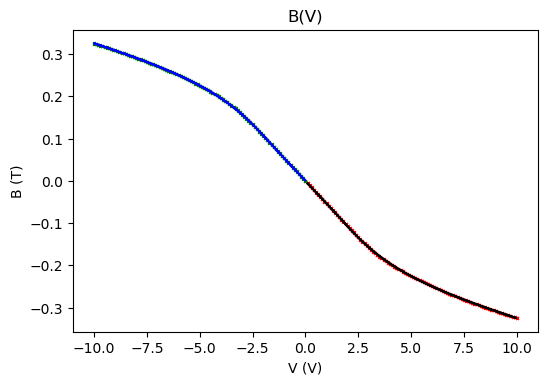

In [24]:
plt.figure(dpi=100)

plt.plot(cen_vp.V, cen_vp.Yfield, 'rx', markersize=2)
plt.plot(cen_vp_fit(cen_vp.Yfield), cen_vp.Yfield , 'k')

plt.plot(cen_vn.V, cen_vn.Yfield, 'gx', markersize=2)
plt.plot(cen_vn_fit(cen_vn.Yfield), cen_vn.Yfield , 'b')
plt.xlabel('V (V)')
plt.ylabel('B (T)')
plt.title('B(V)')

# Radial Calibration 2 V

In [25]:
vp = pd.read_csv('./2019-06-29/2vp_daedalus_radialPolar_calib_A000.0_2019-06-29_1.csv', comment='#')
vn = pd.read_csv('./2019-06-29/2vn_daedalus_radialPolar_calib_A000.0_2019-06-29_1.csv', comment='#')

In [26]:
vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

In [27]:
vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

### OOP field

In [86]:
vp_ds.where(abs(vp_ds.theta) == abs(vp_ds.theta).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 -5.329e-14
Data variables:
    Xfield        (R) float64 -0.0001705
    Yfield        (R) float64 -0.2249
    Zfield        (R) float64 0.0007305
    theta         (R) float64 0.1861
    phi           (R) float64 -180.0
    elapsed_time  (R) float64 245.1
    Bmag          (R) float64 0.2249

In [87]:
vp_ds.where(abs(vn_ds.theta-90.0) == abs(vn_ds.theta-90.0).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 14.4
Data variables:
    Xfield        (R) float64 -0.005288
    Yfield        (R) float64 -0.0002951
    Zfield        (R) float64 -0.1368
    theta         (R) float64 -89.88
    phi           (R) float64 -93.19
    elapsed_time  (R) float64 422.2
    Bmag          (R) float64 0.1368

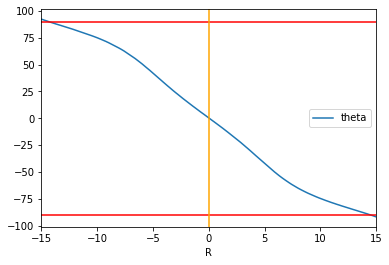

In [28]:
vp.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

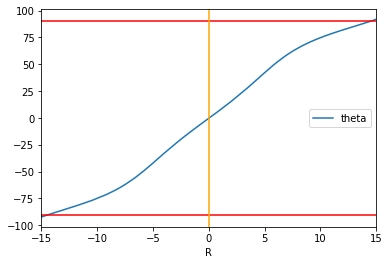

In [29]:
vn.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [30]:
vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

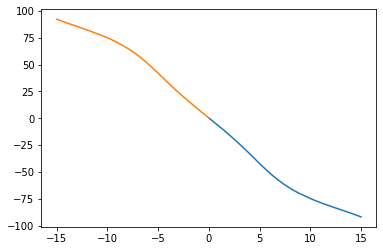

In [31]:
plt.plot(vp_rp.R, vp_rp.theta)
plt.plot(vp_rn.R, vp_rn.theta)

### Positive and Negative field discrepancy is <0.5$^\circ$ 

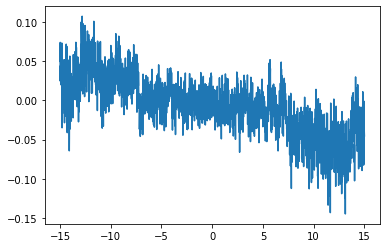

In [32]:
plt.plot(vp.R, (vp.theta+vn.theta))

### Negative voltage R-theta relation

In [33]:
vn_R_thetapos_coeff = np.polyfit(vn_rp.theta, vn_rp.R, 6)
vn_R_thetaneg_coeff = np.polyfit(vn_rn.theta, vn_rn.R, 6)
vn_R_thetapos = np.poly1d(vn_R_thetapos_coeff)
vn_R_thetaneg = np.poly1d(vn_R_thetaneg_coeff)
R_theta = vn_R_thetapos_coeff,vn_R_thetaneg_coeff
print(R_theta)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta, delimiter=",")

(array([-1.90212710e-10,  4.71871199e-08, -4.13023539e-06,  1.69085030e-04,
       -3.66116335e-03,  1.59001919e-01, -1.77628617e-02]), array([1.82659918e-10, 4.57587412e-08, 4.04171643e-06, 1.66094106e-04,
       3.57920896e-03, 1.60044130e-01, 8.66686519e-02]))


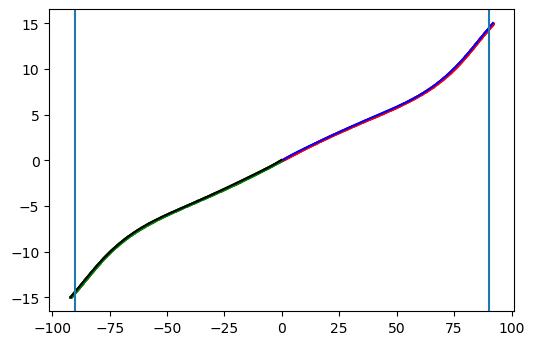

In [35]:
plt.figure(dpi=100)
plt.plot(vn_rp.theta, vn_rp.R, 'r+', markersize=2)
plt.plot(vn_rp.theta, vn_R_thetapos(vn_rp.theta), 'b')
plt.plot(vn_rn.theta, vn_rn.R, 'g+', markersize=2)
plt.plot(vn_rn.theta, vn_R_thetaneg(vn_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

In [36]:
bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

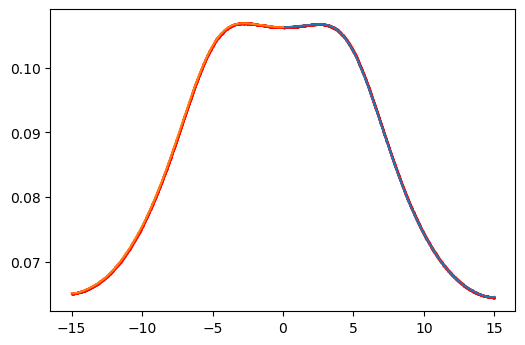

In [37]:
plt.figure(dpi=100)
plt.plot(vp.R, vp.Bmag, 'r+', markersize=2)
plt.plot(vp[vp.R>0].R, bmag_vp_rp(vp[vp.R>0].R))
plt.plot(vp[vp.R<0].R, bmag_vp_rn(vp[vp.R<0].R))

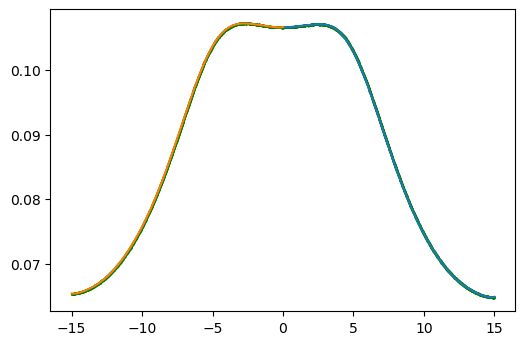

In [38]:
plt.figure(dpi=100)
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

### Voltage Correction function

In [67]:
V0 = cen_vn_fit(bmag_vn_rp(0.0)) # Voltage used for radial scan
Rpts_p = np.arange(0, 15, 0.1)
Rpts_n = np.arange(-15, 0, 0.1)

In [76]:
vcent_vp_rp = V0/cen_vp_fit(-bmag_vp_rp(Rpts_p))
vcent_vp_rn = V0/cen_vp_fit(-bmag_vp_rn(Rpts_n))
vcent_vn_rp = V0/cen_vn_fit(bmag_vn_rp(Rpts_p))
vcent_vn_rn = V0/cen_vn_fit(bmag_vn_rn(Rpts_n))

In [77]:
n = 10
vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

In [78]:
print(vcorr_vp_rp_coeff, '\n', vcorr_vp_rn_coeff, '\n', vcorr_vn_rp_coeff, '\n',vcorr_vn_rn_coeff)

[ 4.86737347e-10 -3.84555377e-08  1.28339354e-06 -2.33804598e-05
  2.50233378e-04 -1.57558346e-03  5.63515032e-03 -1.17018739e-02
  1.36019198e-02 -5.35975488e-03 -1.00730464e+00] 
 [ 5.96838953e-10  4.68355995e-08  1.55854489e-06  2.84824323e-05
  3.08747557e-04  1.99991551e-03  7.52567294e-03  1.64946382e-02
  2.00691528e-02  8.92432490e-03 -1.00676697e+00] 
 [-5.41430574e-10  4.20866365e-08 -1.38359981e-06  2.48727675e-05
 -2.63326689e-04  1.64570190e-03 -5.86816702e-03  1.21711467e-02
 -1.40926736e-02  5.51278040e-03  9.99665260e-01] 
 [-5.63539878e-10 -4.45571611e-08 -1.49448751e-06 -2.75387436e-05
 -3.01173457e-04 -1.97078693e-03 -7.51597878e-03 -1.67826623e-02
 -2.08513799e-02 -9.56572137e-03  9.99131840e-01]


In [79]:
vcorr_coeffs = [vcorr_vp_rp_coeff, vcorr_vn_rp_coeff, vcorr_vp_rn_coeff, vcorr_vn_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

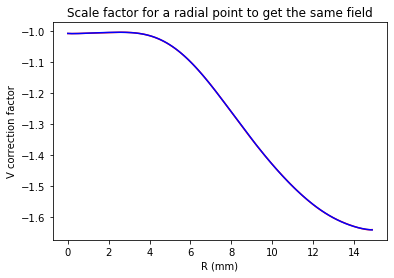

In [72]:
plt.plot(Rpts_p, vcent_vp_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

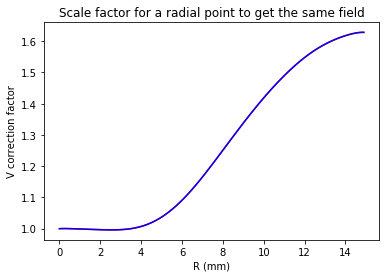

In [80]:
plt.plot(Rpts_p, vcent_vn_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

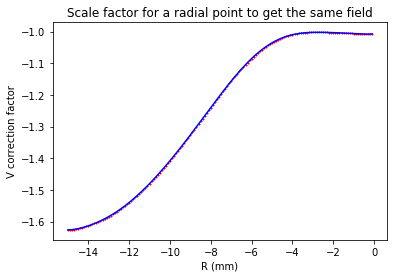

In [74]:
plt.plot(Rpts_n, vcent_vp_rn, 'r+', markersize = 2)
plt.plot(Rpts_n, vcorr_vp_rn(Rpts_n), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

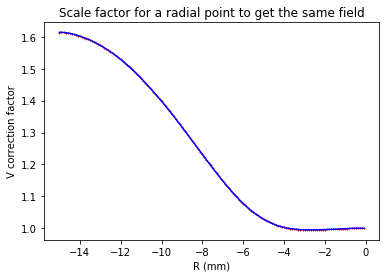

In [81]:
plt.plot(Rpts_n, vcent_vn_rn, 'r+', markersize = 2)
plt.plot(Rpts_n, vcorr_vn_rn(Rpts_n), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

# Radial Calibration 5 V

In [83]:
vp = pd.read_csv('./2019-06-29/test_daedalus_radialPolar_calib_A000.0_2019-06-29_6.csv', comment='#')
vn = pd.read_csv('./2019-06-29/test_daedalus_radialPolar_calib_A000.0_2019-06-29_7.csv', comment='#')

In [84]:
vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

In [85]:
vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

### OOP field

In [86]:
vp_ds.where(abs(vp_ds.theta) == abs(vp_ds.theta).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 -5.329e-14
Data variables:
    Xfield        (R) float64 -0.0001705
    Yfield        (R) float64 -0.2249
    Zfield        (R) float64 0.0007305
    theta         (R) float64 0.1861
    phi           (R) float64 -180.0
    elapsed_time  (R) float64 245.1
    Bmag          (R) float64 0.2249

In [87]:
vp_ds.where(abs(vn_ds.theta-90.0) == abs(vn_ds.theta-90.0).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 14.4
Data variables:
    Xfield        (R) float64 -0.005288
    Yfield        (R) float64 -0.0002951
    Zfield        (R) float64 -0.1368
    theta         (R) float64 -89.88
    phi           (R) float64 -93.19
    elapsed_time  (R) float64 422.2
    Bmag          (R) float64 0.1368

<IPython.core.display.Javascript object>


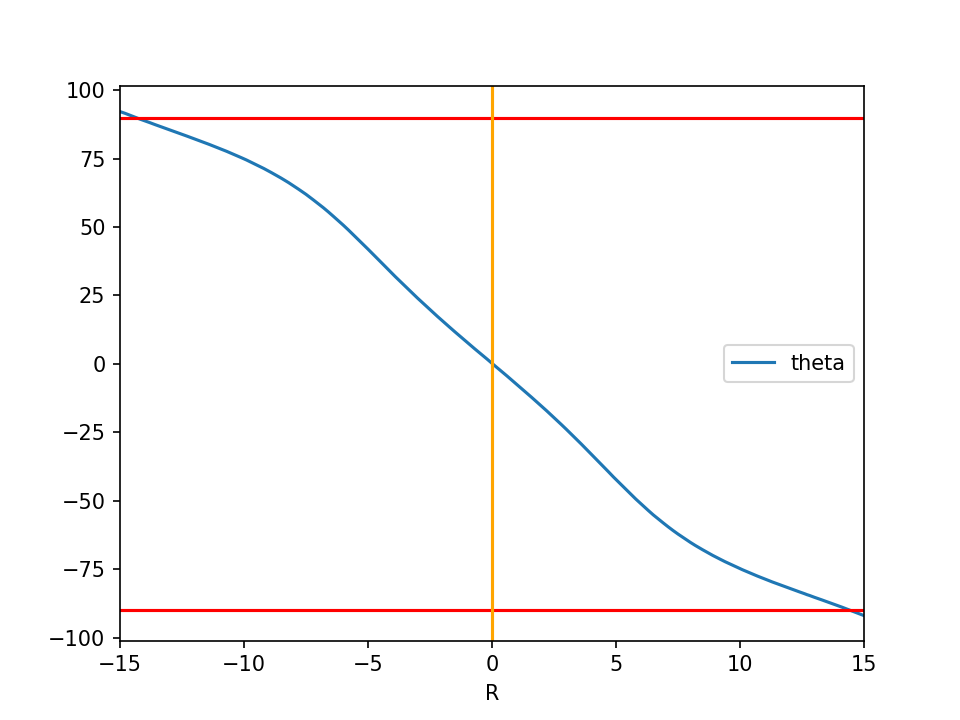

In [88]:
vp.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

<IPython.core.display.Javascript object>


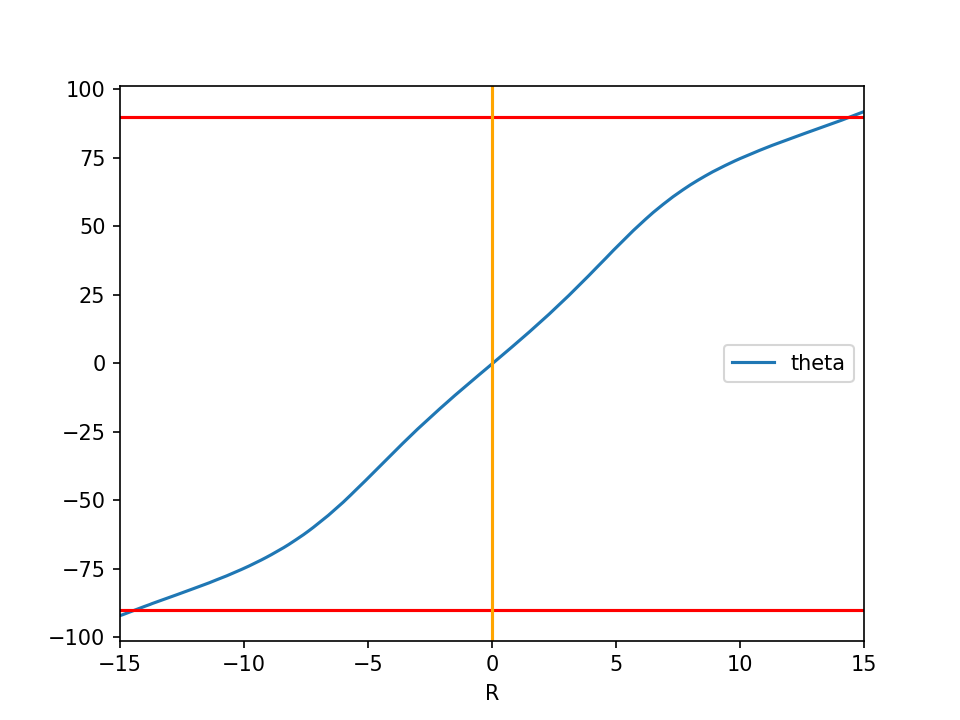

In [89]:
vn.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [90]:
vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

<IPython.core.display.Javascript object>


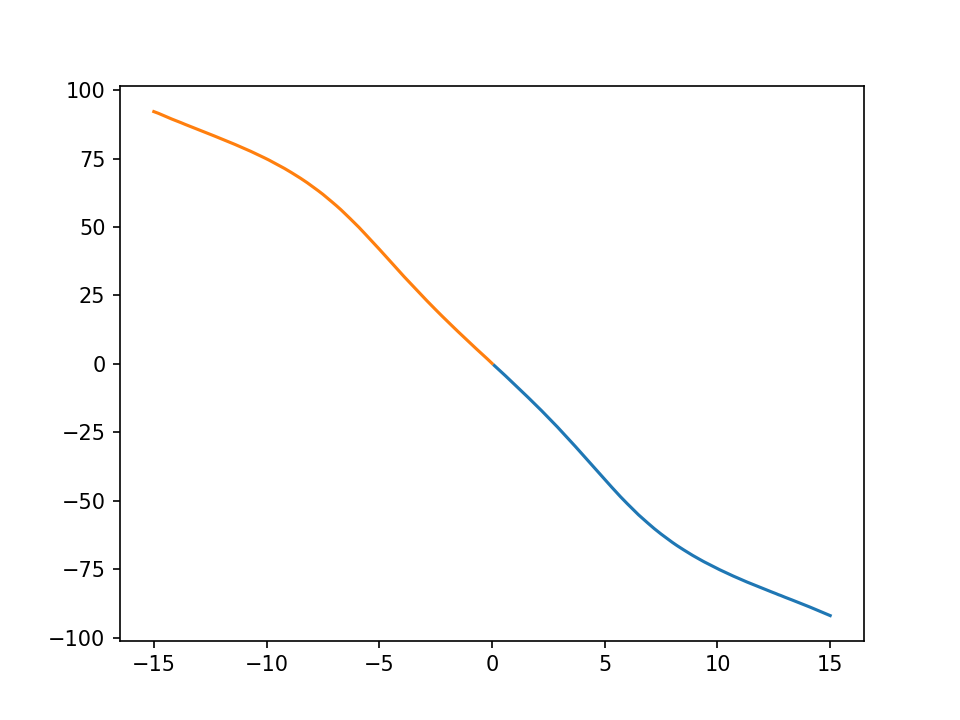

In [185]:
plt.plot(vp_rp.R, vp_rp.theta)
plt.plot(vp_rn.R, vp_rn.theta)

### Positive and Negative field discrepancy is <0.5$^\circ$ 

<IPython.core.display.Javascript object>


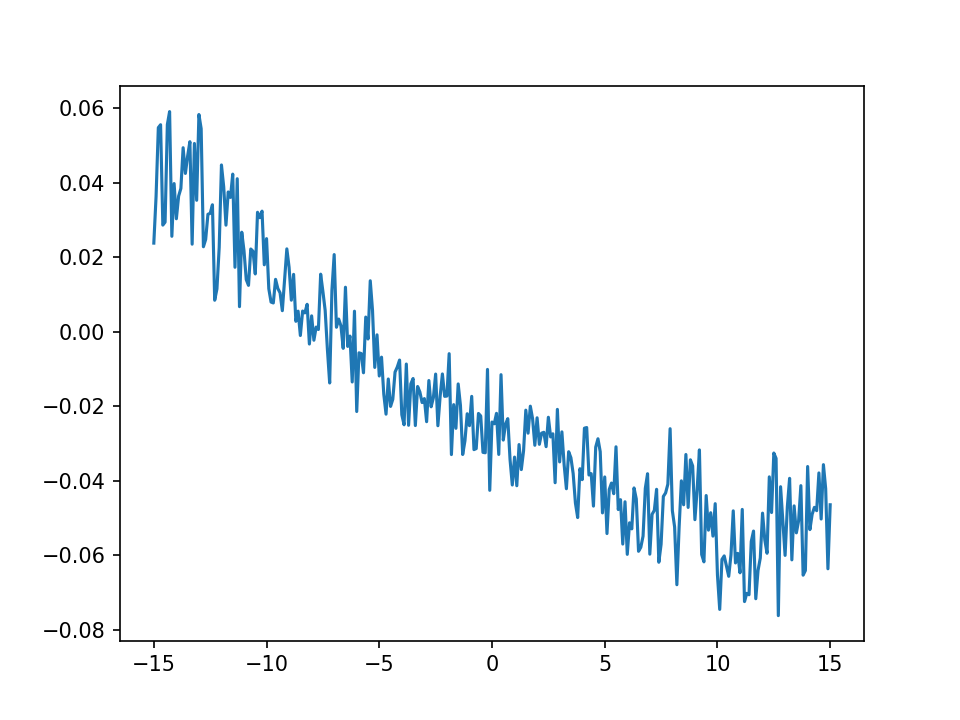

In [92]:
plt.plot(vp.R, (vp.theta+vn.theta))

### Negative voltage R-theta relation

In [213]:
vn_R_thetapos_coeff = np.polyfit(vn_rp.theta, vn_rp.R, 6)
vn_R_thetaneg_coeff = np.polyfit(vn_rn.theta, vn_rn.R, 6)
vn_R_thetapos = np.poly1d(vn_R_thetapos_coeff)
vn_R_thetaneg = np.poly1d(vn_R_thetaneg_coeff)
R_theta = vn_R_thetapos_coeff,vn_R_thetaneg_coeff
print(R_theta)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta, delimiter=",")

(array([-1.95869810e-10,  4.88382800e-08, -4.31408017e-06,  1.78794722e-04,
       -3.90774631e-03,  1.61726809e-01, -2.88952261e-02]), array([1.78970529e-10, 4.46818692e-08, 3.91808162e-06, 1.59149757e-04,
       3.38647789e-03, 1.57763591e-01, 7.76067007e-02]))


In [211]:
vn_R_thetaneg(-45)

-5.359007565050679

<IPython.core.display.Javascript object>


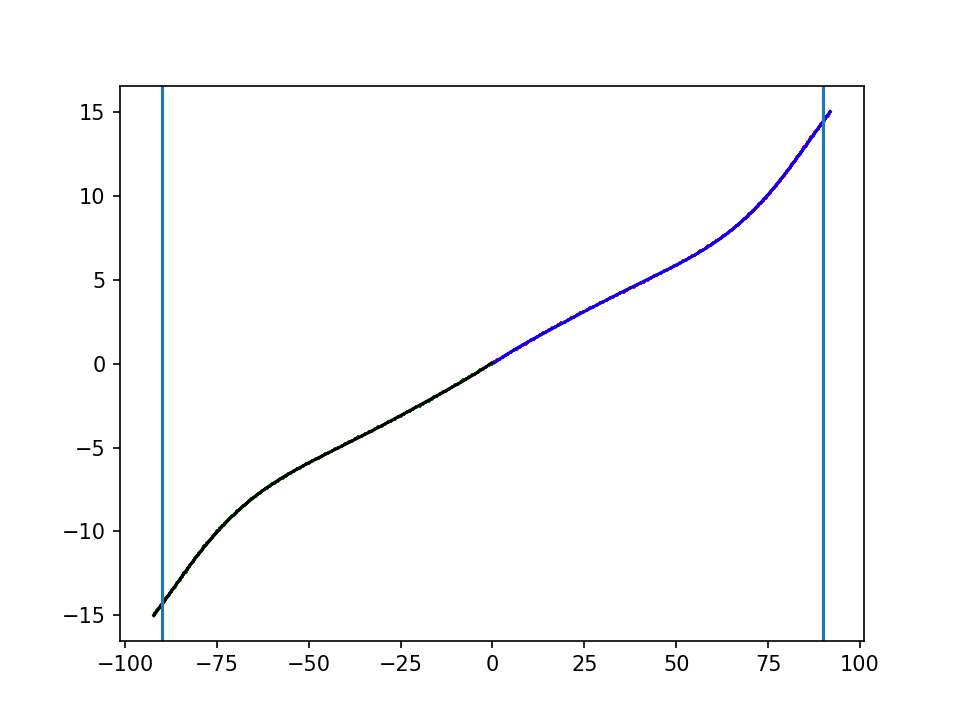

In [210]:
plt.figure(dpi=100)
plt.plot(vn_rp.theta, vn_rp.R, 'r+', markersize=2)
plt.plot(vn_rp.theta, vn_R_thetapos(vn_rp.theta), 'b')
plt.plot(vn_rn.theta, vn_rn.R, 'g+', markersize=2)
plt.plot(vn_rn.theta, vn_R_thetaneg(vn_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

In [214]:
bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

<IPython.core.display.Javascript object>


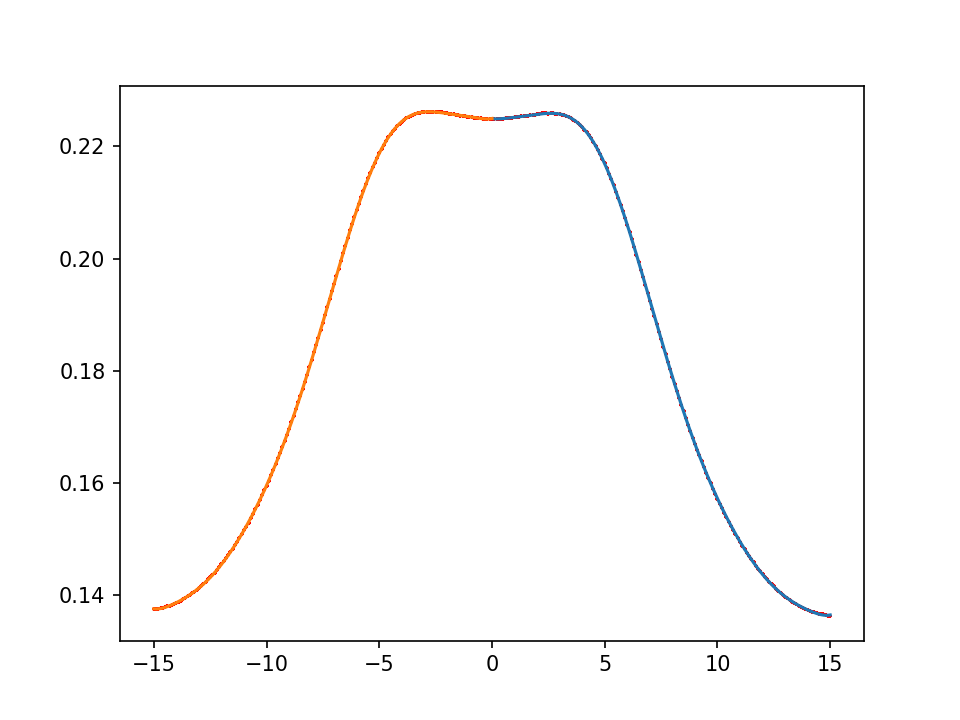

In [215]:
plt.figure(dpi=100)
plt.plot(vp.R, vp.Bmag, 'r+', markersize=2)
plt.plot(vp[vp.R>0].R, bmag_vp_rp(vp[vp.R>0].R))
plt.plot(vp[vp.R<0].R, bmag_vp_rn(vp[vp.R<0].R))

<IPython.core.display.Javascript object>


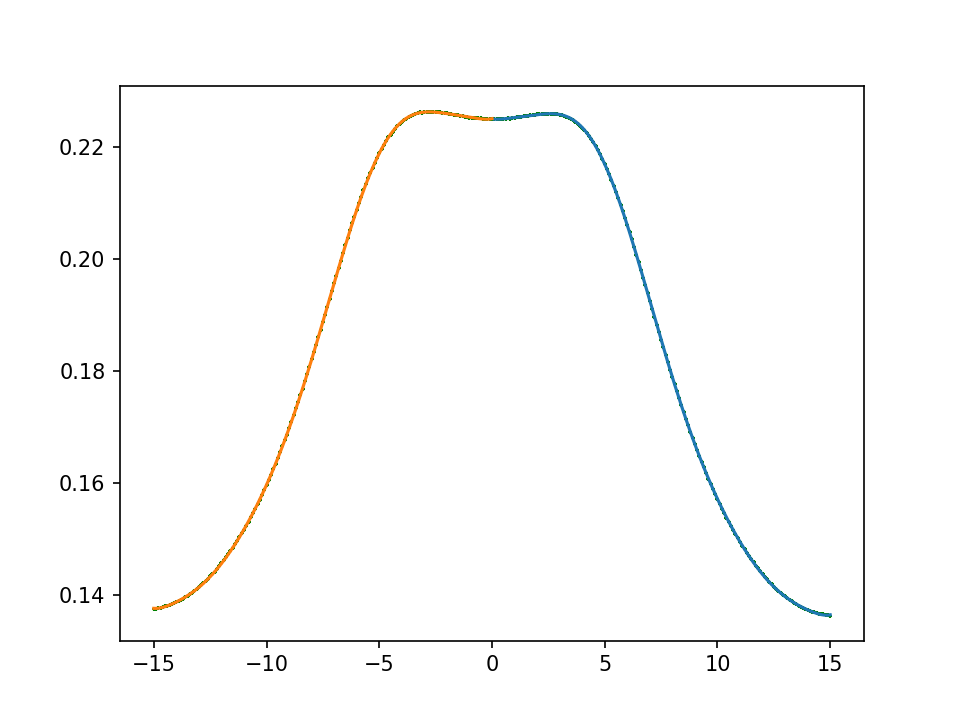

In [216]:
plt.figure(dpi=100)
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

### Voltage Correction function

In [40]:
V0 = 2.0 # Voltage used for radial scan
Rpts_p = np.arange(0, 15, 0.1)
Rpts_n = np.arange(-15, 0, 0.1)

In [41]:
cen_vp_fit(bmag_vp_rp(Rpts_p))

array([-0.60825913, -0.6087032 , -0.60882996, -0.60872789, -0.60846523,
       -0.60809354, -0.60765076, -0.60716383, -0.606651  , -0.60612384,
       -0.60558897, -0.60504955, -0.60450658, -0.60395995, -0.60340938,
       -0.60285514, -0.60229865, -0.60174292, -0.60119295, -0.60065587,
       -0.60014117, -0.5996607 , -0.59922866, -0.59886151, -0.59857783,
       -0.59839812, -0.5983445 , -0.59844052, -0.59871074, -0.59918041,
       -0.59987512, -0.60082036, -0.60204116, -0.60356163, -0.6054046 ,
       -0.60759122, -0.61014055, -0.61306924, -0.61639116, -0.62011716,
       -0.62425482, -0.6288082 , -0.63377776, -0.63916022, -0.64494854,
       -0.65113195, -0.65769602, -0.66462277, -0.67189093, -0.67947609,
       -0.68735103, -0.69548605, -0.70384928, -0.7124071 , -0.72112452,
       -0.72996556, -0.73889373, -0.74787237, -0.75686509, -0.76583613,
       -0.77475072, -0.7835754 , -0.79227837, -0.80082966, -0.80920145,
       -0.81736819, -0.82530677, -0.83299662, -0.84041978, -0.84

In [218]:
vcent_vp_rp = -V0/cen_vp_fit(bmag_vp_rp(Rpts_p))
vcent_vp_rn = -V0/cen_vp_fit(bmag_vp_rn(Rpts_n))
vcent_vn_rp = V0/cen_vn_fit(-bmag_vn_rp(Rpts_p))
vcent_vn_rn = V0/cen_vn_fit(-bmag_vn_rn(Rpts_n))

In [219]:
n = 10
vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

In [220]:
print(vcorr_vp_rp_coeff, '\n', vcorr_vp_rn_coeff, '\n', vcorr_vn_rp_coeff, '\n',vcorr_vn_rn_coeff)

[-9.42331165e-10  7.41034637e-08 -2.45624959e-06  4.43429809e-05
 -4.69357653e-04  2.91994833e-03 -1.03298271e-02  2.11780572e-02
 -2.43833885e-02  9.87628200e-03  1.00350187e+00] 
 [-9.44434919e-10 -7.51826633e-08 -2.53220109e-06 -4.66800595e-05
 -5.08069896e-04 -3.28504973e-03 -1.22561930e-02 -2.64672662e-02
 -3.16043075e-02 -1.35086769e-02  1.00287263e+00] 
 [-9.30405433e-10  7.34372262e-08 -2.44323745e-06  4.42695099e-05
 -4.70217671e-04  2.93461889e-03 -1.04072592e-02  2.13341400e-02
 -2.43861397e-02  9.62718412e-03  1.00333192e+00] 
 [-8.72202392e-10 -7.02465331e-08 -2.39210016e-06 -4.45501621e-05
 -4.89467141e-04 -3.19277689e-03 -1.20243087e-02 -2.63115331e-02
 -3.19744741e-02 -1.39442471e-02  1.00245321e+00]


In [201]:
vcorr_coeffs = [vcorr_vp_rp_coeff, vcorr_vn_rp_coeff, vcorr_vp_rn_coeff, vcorr_vn_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

In [202]:
plt.plot(Rpts_p, vcent_vp_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1, 'Scale factor for a radial point to get the same field')

<IPython.core.display.Javascript object>


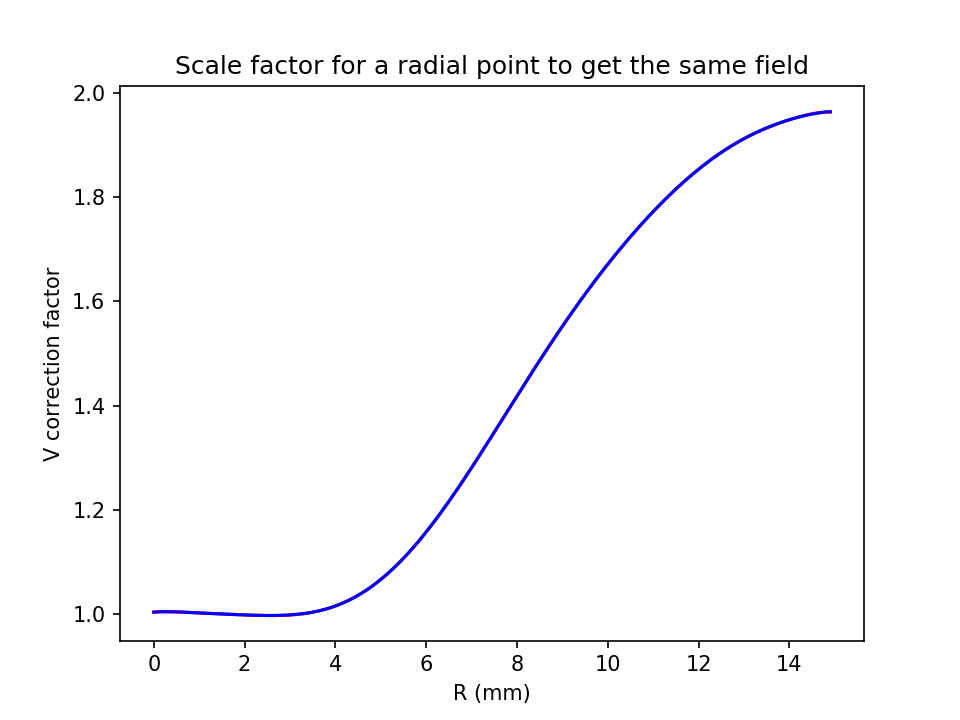

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

In [188]:
plt.plot(Rpts_p, vcent_vn_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

<IPython.core.display.Javascript object>


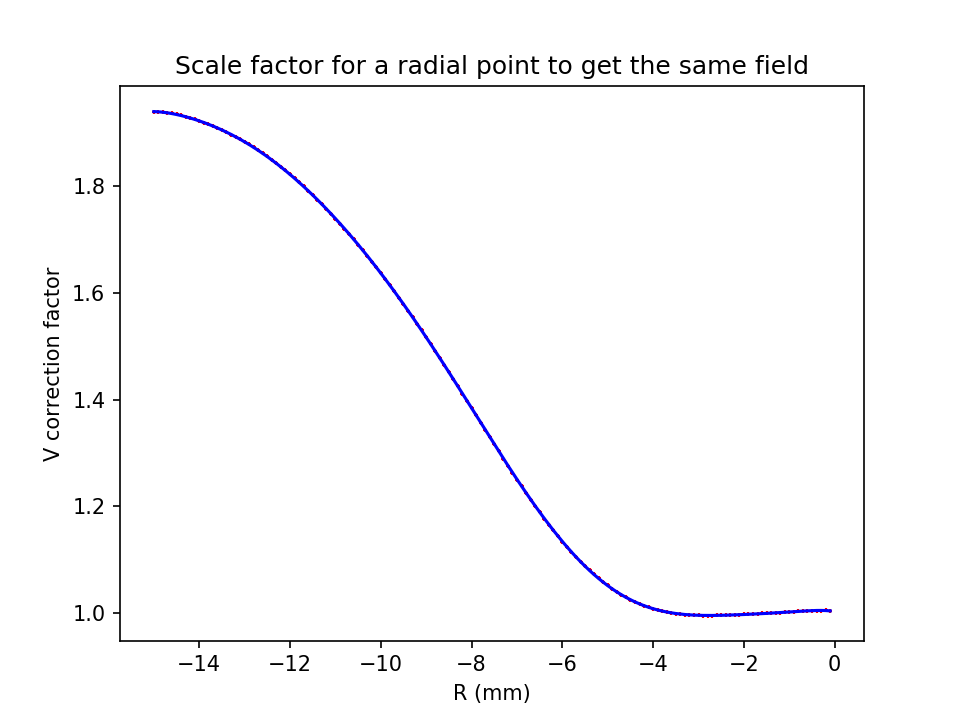

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

In [189]:
plt.plot(Rpts_n, vcent_vp_rn, 'r+', markersize = 2)
plt.plot(Rpts_n, vcorr_vp_rn(Rpts_n), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

<IPython.core.display.Javascript object>


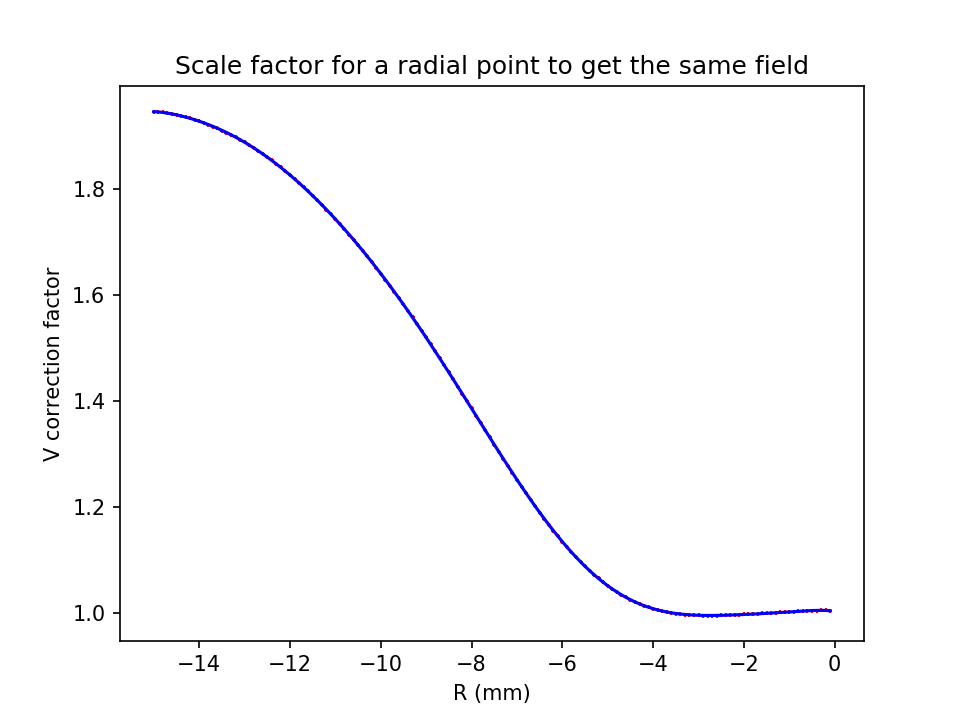

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

In [190]:
plt.plot(Rpts_n, vcent_vn_rn, 'r+', markersize = 2)
plt.plot(Rpts_n, vcorr_vn_rn(Rpts_n), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')